In [197]:
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import nltk 
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import re
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

# Import our text vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Import our classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Import some ML helper function
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

# Import our metrics to evaluate our model
from sklearn import metrics


In [198]:
df = pd.read_csv('labeled_lyrics_w_genres.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,artist,seq,song,label,genre
0,0,0,Elijah Blake,"No, no\r\nI ain't ever trapped out the bando\r...",Everyday,0.626,R&B
1,1,1,Elijah Blake,"The drinks go down and smoke goes up, I feel m...",Live Till We Die,0.630,Pop
2,2,2,Elijah Blake,She don't live on planet Earth no more\r\nShe ...,The Otherside,0.240,R&B
3,3,3,Elijah Blake,"Trippin' off that Grigio, mobbin', lights low\...",Pinot,0.536,R&B
4,4,4,Elijah Blake,"I see a midnight panther, so gallant and so br...",Shadows & Diamonds,0.371,R&B


In [199]:
df = df.drop(columns = ['Unnamed: 0','Unnamed: 0.1'],axis = 1)

In [200]:
df.genre.value_counts()

Pop          57357
No_genre     42789
Rock         26756
Country       7440
Rap           5959
R&B           4773
Non-Music      176
Name: genre, dtype: int64

Removing Non Genres

In [201]:
df_dropped = df[(df['genre'] == 'No_genre') | (df['genre'] == 'Non-Music')].index
df.drop(df_dropped, inplace=True, axis='index')

In [202]:
df['genre'].value_counts()

Pop        57357
Rock       26756
Country     7440
Rap         5959
R&B         4773
Name: genre, dtype: int64

## Dealing with Class Imbalance

In [235]:
df_balanced = ""

cond = df['genre'] == 'Pop'
df_pop = df[cond]
df_pop = df_pop[0:9000]

cond = df['genre'] == 'Rock'
df_rock = df[cond]
df_rock = df_rock[0:6000]
df_rock.shape

cond = df['genre'] == 'Country'
df_country = df[cond]
df_country = df_country[0:5000]
df_country.shape

cond = df['genre'] == 'Rap'
df_rap = df[cond]
df_rap = df_rap[0:5950]
df_rap.shape

cond = df['genre'] == 'R&B'
df_r_b = df[cond]
df_r_b = df_r_b[0:4000]
df_r_b.shape

(4000, 5)

In [236]:
df_balanced = pd.concat([df_pop, df_rock, df_country, df_rap, df_r_b], axis = 0)

In [237]:
df_balanced['genre'].value_counts()

Pop        9000
Rock       6000
Rap        5950
Country    5000
R&B        4000
Name: genre, dtype: int64

In [211]:
df_balanced

,artist,seq,song,label,genre
1,Elijah Blake,"The drinks go down and smoke goes up, I feel m...",Live Till We Die,0.630,Pop
7,Elis,Dieses ist lange her.\r\nDa ich deine schmalen...,Abendlied,0.333,Pop
8,Elis,A child is born\r\nOut of the womb of a mother...,Child,0.506,Pop
9,Elis,Out of the darkness you came \r\nYou looked so...,Come to Me,0.179,Pop
10,Elis,Each night I lie in my bed \r\nAnd I think abo...,Do You Believe,0.209,Pop
...,...,...,...,...,...
124730,Conway Twitty,"Lookin' back over my life\nI can see where, wh...",Looking Back,0.732,R&B
124764,Donell Jones,[Chorus:]\r\nWaiting on you \r\nI'm not going ...,Waiting on You,0.468,R&B
124791,Big Joe Turner,How about it? How about it? It takes a lot of ...,The Chill Is On,0.542,R&B
124830,Sam Cooke,"(Send me some loving)\r\nMmm, send it, I pray\...",Send Me Some Lovin,0.685,R&B


## Data Cleaning

In [212]:
#Remove numbers
def remove_numbers(input):
    input = word_tokenize(input)
    without_sw = [word for word in input 
                  if word.isalpha()]
    return ' '.join(without_sw)

# 1. function that makes all text lowercase.
def make_lowercase(test_string):
    return test_string.lower()

# 2. function that removes all punctuation. 
def remove_punc(test_string):
    test_string = re.sub(r'[^\w\s]', '', test_string)
    return test_string

# 3. function that removes all stopwords.
def remove_sw(input):
    input = word_tokenize(input)
    without_sw = [word for word in input 
                  if word not in stopwords]
    return ' '.join(without_sw)

# 4. function to break words into their stem words
def stem_words(input):
    stemming = PorterStemmer()
    tokenized_words = word_tokenize(input)
    
    stemmed_words = [stemming.stem(word) for word in tokenized_words]
    return ' '.join(stemmed_words)

In [213]:
# Pipeline

def text_processing_pipeline(a_string):
    a_string = make_lowercase(a_string)
    a_string = remove_numbers(a_string)
    a_string = remove_punc(a_string)
    a_string = remove_sw(a_string)
    #a_string = stem_words(a_string)
    return a_string

In [214]:
df_balanced['seq_clean'] = df_balanced['seq'].apply(lambda x: text_processing_pipeline(x))

In [215]:
df_balanced.head()

,artist,seq,song,label,genre,seq_clean
1,Elijah Blake,"The drinks go down and smoke goes up, I feel m...",Live Till We Die,0.630,Pop,drinks go smoke goes feel got let go cares get...
7,Elis,Dieses ist lange her.\r\nDa ich deine schmalen...,Abendlied,0.333,Pop,dieses ist lange da ich deine schmalen hande n...
8,Elis,A child is born\r\nOut of the womb of a mother...,Child,0.506,Pop,child born womb mother want happened night dru...
9,Elis,Out of the darkness you came \r\nYou looked so...,Come to Me,0.179,Pop,darkness came looked tired sad asked answered ...
10,Elis,Each night I lie in my bed \r\nAnd I think abo...,Do You Believe,0.209,Pop,night lie bed think oh dark friend give answer...


# TF/IDF

In [216]:
# Define our `X` and `y` data. 

X = df_balanced['seq_clean'].values

y = df_balanced['genre'].values

In [217]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=44)


In [218]:
X_train.shape

(23960,)

### Vectorizer

In [219]:
#initialize vec
vectorizer = TfidfVectorizer()

#Making voacb Matrix
vectorizer.fit(X_train)

# This transforms your documents into vectors.
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [220]:
print(X_train.shape, type(X))

(23960, 62781) <class 'numpy.ndarray'>


In [221]:
vectorizer.vocabulary_

{'inside': 27765,
 'heart': 24924,
 'every': 18519,
 'man': 33097,
 'much': 35938,
 'understand': 58111,
 'love': 32347,
 'gone': 23061,
 'away': 3121,
 'passion': 39677,
 'stares': 52326,
 'face': 19077,
 'could': 12063,
 'walk': 60123,
 'ears': 16950,
 'open': 38380,
 'help': 25177,
 'brave': 6516,
 'devotion': 14729,
 'save': 47391,
 'wan': 60184,
 'na': 36372,
 'stray': 52955,
 'hallow': 24308,
 'ground': 23751,
 'turn': 57475,
 'temptation': 55075,
 'asking': 2583,
 'take': 54510,
 'safety': 46973,
 'time': 55921,
 'forgive': 20990,
 'thoughts': 55570,
 'asleep': 2586,
 'words': 61712,
 'yet': 62269,
 'speak': 51521,
 'feel': 19623,
 'ashamed': 2546,
 'right': 45877,
 'seem': 48146,
 'far': 19338,
 'confusion': 11270,
 'clouds': 10288,
 'mind': 34772,
 'know': 30201,
 'path': 39730,
 'resist': 45331,
 'slave': 50238,
 'onto': 38257,
 'mercy': 34313,
 'long': 32139,
 'wrong': 61914,
 'never': 36940,
 'live': 31864,
 'without': 61491,
 'come': 10730,
 'back': 3297,
 'brighter': 6736

In [222]:
print(X_train) #1st word in 1st row's frequency 

  (0, 62269)	0.06402198547991839
  (0, 61914)	0.05074718155282416
  (0, 61712)	0.05436210047121615
  (0, 61491)	0.05103515453691392
  (0, 60184)	0.09403011809059567
  (0, 60123)	0.05146350346366775
  (0, 58111)	0.057334651966015684
  (0, 57475)	0.09572931893160382
  (0, 55921)	0.059713800542370944
  (0, 55570)	0.07045993903751306
  (0, 55075)	0.1937078806685626
  (0, 54510)	0.13530232061780087
  (0, 52955)	0.2013709228695063
  (0, 52326)	0.10724747699525522
  (0, 51521)	0.06428767932034525
  (0, 50238)	0.0853281902889294
  (0, 48146)	0.06393991245729441
  (0, 47391)	0.13182827982303638
  (0, 46973)	0.30623008813716973
  (0, 45877)	0.03581498105686177
  (0, 45331)	0.09147633260498338
  (0, 39730)	0.08155223370569686
  (0, 39677)	0.08282326377114506
  (0, 38380)	0.1124363142113435
  (0, 38257)	0.09087243741661602
  :	:
  (23958, 13573)	0.30765180898539773
  (23958, 12063)	0.05735079664617393
  (23958, 11733)	0.20401522098307168
  (23958, 10730)	0.2720222701119811
  (23959, 62190)	0.13655

In [223]:
features = vectorizer.get_feature_names_out()
weights = vectorizer.idf_

print(len(features), len(weights))

df_idf = pd.DataFrame.from_dict( {'feature': features, 'idf': weights})

df_idf = df_idf.sort_values(by='idf', ascending=False)

df_idf

62781 62781


,feature,idf
31390,lett,10.391036
34230,meningitis,10.391036
34223,menfolk,10.391036
34224,mengapa,10.391036
34225,mengenal,10.391036
...,...,...
48125,see,1.958529
32347,love,1.876847
23200,got,1.855610
31625,like,1.715814


In [224]:
for i in range(1000, 1010):
    print(features_names[i])

acerca
acerco
acey
aceyaalon
aceyalon
acguitar
ach
achas
acheivin
achey


## Build and train our model


In [225]:
# Initalize our model.
model = MultinomialNB(alpha=.05)

# Fit our model with our training data.
model.fit(X_train, y_train)

# Make new predictions of our testing data. 
y_pred = model.predict(X_test)

# Make predicted probabilites of our testing data
y_pred_proba = model.predict_proba(X_test)

# Evaluate our model
accuracy =  model.score(X_test, y_test)

# Print our evaluation metrics
print("Model Accuracy: %f" % accuracy)

Model Accuracy: 0.536561


In [226]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=model.classes_))

              precision    recall  f1-score   support

     Country       0.60      0.40      0.48      1010
         Pop       0.41      0.71      0.52      1734
         R&B       0.57      0.26      0.36       825
         Rap       0.79      0.83      0.81      1217
        Rock       0.54      0.29      0.38      1204

    accuracy                           0.54      5990
   macro avg       0.58      0.50      0.51      5990
weighted avg       0.57      0.54      0.52      5990



C:\Users\dip2l\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


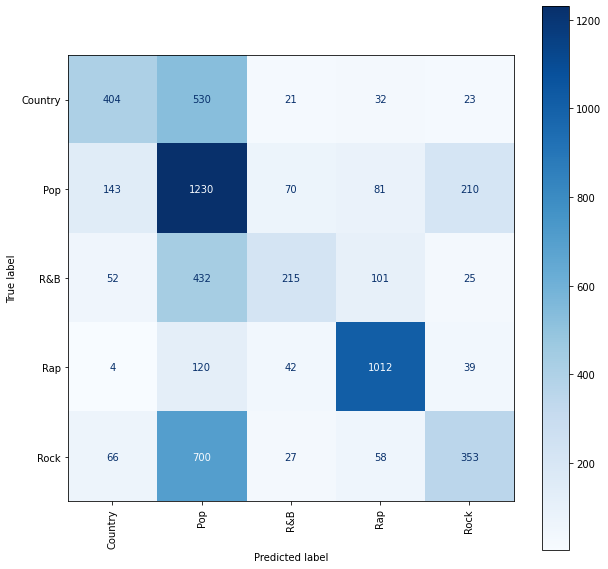

In [227]:
# Plot the confusion matrix of our results
fig, ax = plt.subplots(figsize=(10, 10))

disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=model.classes_,
                             cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=90)
disp

## RandomForestClassifier

In [228]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()


# Fit our model with our training data.
rf_model.fit(X_train, y_train)


# Make new predictions of our testing data. 
y_pred = rf_model.predict(X_test)


# Make predicted probabilites of our testing data
y_pred_proba = rf_model.predict_proba(X_test)

# Evaluate our model
accuracy =  rf_model.score(X_test, y_test)

# Print our evaluation metrics
print("Model Accuracy: %f" % accuracy)

print(classification_report(y_test, y_pred, target_names=rf_model.classes_))

Model Accuracy: 0.505676
              precision    recall  f1-score   support

     Country       0.67      0.22      0.33      1010
         Pop       0.38      0.86      0.53      1734
         R&B       0.58      0.16      0.24       825
         Rap       0.84      0.84      0.84      1217
        Rock       0.53      0.14      0.22      1204

    accuracy                           0.51      5990
   macro avg       0.60      0.44      0.43      5990
weighted avg       0.58      0.51      0.46      5990



C:\Users\dip2l\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


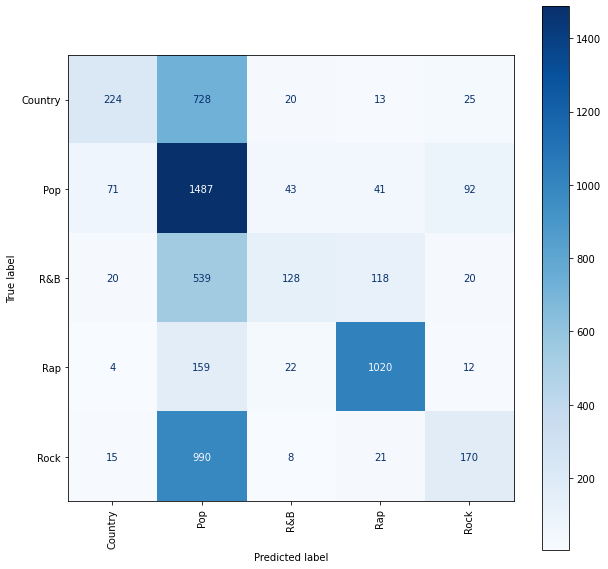

In [229]:
# Plot the confusion matrix of our results
fig, ax = plt.subplots(figsize=(10, 10))
disp = plot_confusion_matrix(rf_model, X_test, y_test,
                             display_labels=rf_model.classes_,
                             cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=90)
disp

## Predict New Test

In [230]:
new_text = '''Ooh
You can dance
You can jive
Having the time of your life
Ooh, see that girl
Watch that scene
Digging the dancing queen
Friday night and the lights are low
Looking out for a place to go
Where they play the right music
Getting in the swing
You come to look for a king
Anybody could be that guy
Night is young and the music's high
With a bit of rock music
Everything is fine
You're in the mood for a dance
And when you get the chance
You are the dancing queen
Young and sweet
Only seventeen
Dancing queen
Feel the beat from the tambourine, oh yeah
You can dance
You can jive
Having the time of your life
Ooh, see that girl
Watch that scene
Digging the dancing queen
You're a teaser, you turn 'em on
Leave 'em burning and then you're gone
Looking out for another
Anyone will do
You're in the mood for a dance
And when you get the chance
You are the dancing queen
Young and sweet
Only seventeen
Dancing queen
Feel the beat from the tambourine, oh yeah
You can dance
You can jive
Having the time of your life
Ooh, see that girl
Watch that scene
Digging the dancing queen
Digging the dancing queen'''

# Feature engineer the same way we did with our original data. 
new_text = text_processing_pipeline(new_text)

# Sanity check
print(new_text)

# Turn the new_text into numbers using the vectorizer
# NOTE, must be passed in as a list.
# NOTE, use just transform here, NOT FIT. 
new_text_vectorized = vectorizer.transform([new_text])

# make a new prediction using our model and vectorized text
model.predict(new_text_vectorized)

ooh dance jive time life ooh see girl watch scene digging dancing queen friday night lights low looking place go play right music getting swing come look king anybody could guy night young music high bit rock music everything fine mood dance get chance dancing queen young sweet seventeen dancing queen feel beat tambourine oh yeah dance jive time life ooh see girl watch scene digging dancing queen teaser turn leave burning gone looking another anyone mood dance get chance dancing queen young sweet seventeen dancing queen feel beat tambourine oh yeah dance jive time life ooh see girl watch scene digging dancing queen digging dancing queen


array(['R&B'], dtype='<U7')

## Embedding

In [231]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [232]:
def word_tokenize(sentences):
    tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)
    tokenizer.fit_on_texts(sentences)
    
    sequences = tokenizer.texts_to_sequences(sentences)
    padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    return padded

In [233]:
df.head()

,artist,seq,song,label,genre
0,Elijah Blake,"No, no\r\nI ain't ever trapped out the bando\r...",Everyday,0.626,R&B
1,Elijah Blake,"The drinks go down and smoke goes up, I feel m...",Live Till We Die,0.630,Pop
2,Elijah Blake,She don't live on planet Earth no more\r\nShe ...,The Otherside,0.240,R&B
3,Elijah Blake,"Trippin' off that Grigio, mobbin', lights low\...",Pinot,0.536,R&B
4,Elijah Blake,"I see a midnight panther, so gallant and so br...",Shadows & Diamonds,0.371,R&B


In [234]:
from imblearn.over_sampling

SyntaxError: invalid syntax (782751034.py, line 1)

In [ ]:
X = df['seq']
y = df['genre']